In [8]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [2]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output: list[int]):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [3]:
# 1a

# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    # TODO
    mid = 2
    return 5 - np.abs(mid - output)

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    # TODO
    noise = np.random.uniform(-0.5, 0.5)  # Adding uniform noise
    return reward_model_ground_truth(output) + noise

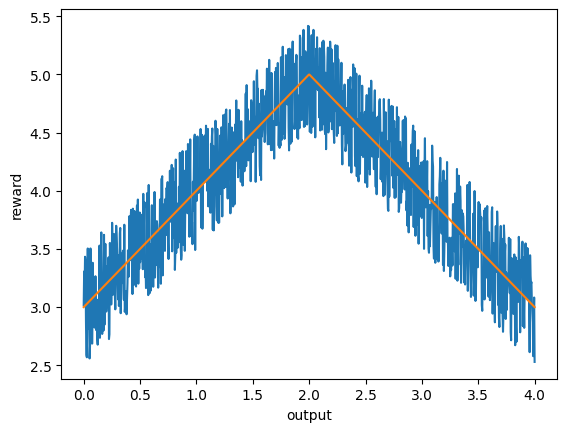

In [4]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.plot(outputs, rewards_proxy, alpha=1.0)
    plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()

N =   1: E[R(π^BoN)] = 3.9483
N =   2: E[R(π^BoN)] = 4.3214
N =   4: E[R(π^BoN)] = 4.5648
N =   8: E[R(π^BoN)] = 4.6866
N =  16: E[R(π^BoN)] = 4.7760
N =  32: E[R(π^BoN)] = 4.8398
N =  64: E[R(π^BoN)] = 4.8880


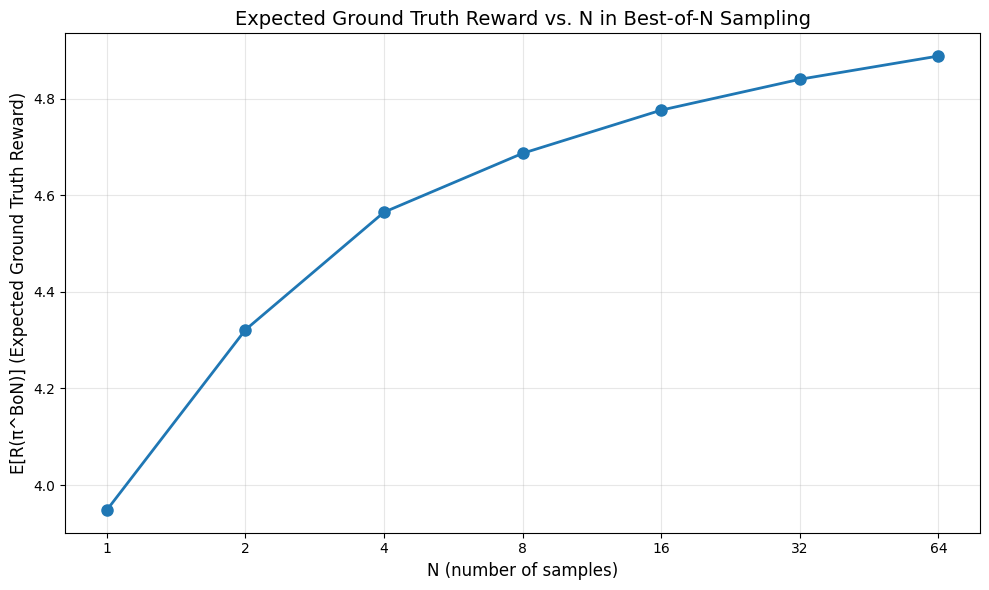

In [5]:
def best_of_n(n: int, reward_model):
    outputs = model(n)
    rewards = [reward_model(output) for output in outputs]

    best_idx = np.argmax(rewards)
    best_output = outputs[best_idx]
    best_reward = rewards[best_idx]

    return best_output, best_reward

def compute_expected_ground_truth_reward(n: int, num_trials: int = 100):
    """
    Compute E[R(π^BoN)] - the expected ground truth reward when using best-of-n
    sampling with the proxy reward model.
    """
    ground_truth_rewards = []

    for _ in range(num_trials):
        best_output, _ = best_of_n(n, reward_model_proxy)

        gt_reward = reward_model_ground_truth(best_output)
        ground_truth_rewards.append(gt_reward)

    return np.mean(ground_truth_rewards)


# 1b
n_values = [1, 2, 4, 8, 16, 32, 64]
expected_rewards = []

for n in n_values:
    exp_reward = compute_expected_ground_truth_reward(n, num_trials=100)
    expected_rewards.append(exp_reward)
    print(f"N = {n:3d}: E[R(π^BoN)] = {exp_reward:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_values, expected_rewards, marker='o', linewidth=2, markersize=8)
plt.xlabel("N (number of samples)", fontsize=12)
plt.ylabel("E[R(π^BoN)] (Expected Ground Truth Reward)", fontsize=12)
plt.title("Expected Ground Truth Reward vs. N in Best-of-N Sampling", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks(n_values, n_values)
plt.tight_layout()
plt.show()

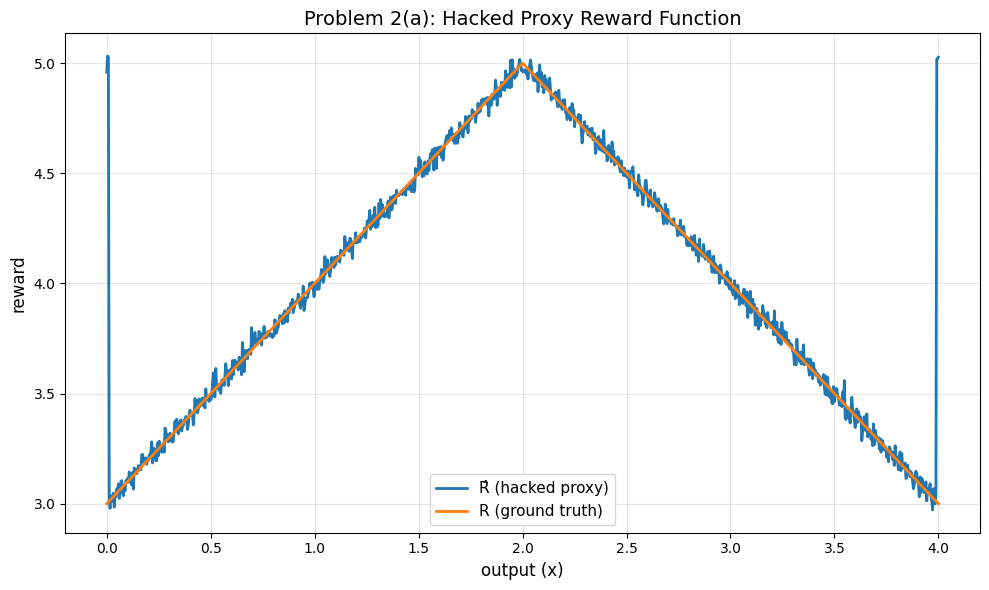

In [6]:
# 2a
def reward_model_proxy_hacked(output) -> float:
    noise = np.random.uniform(-0.5, 0.5)
    # Add noise = 2 when x in [0, 0.01] or [3.99, 4]
    if (0 <= output <= 0.01) or (3.99 <= output <= 4):
        noise += 2
    return reward_model_ground_truth(output) + noise

def plot_hacked_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]

    # For proxy, average over multiple samples to show expected value
    rewards_proxy_hacked = []
    for output in outputs:
        proxy_rewards = [reward_model_proxy_hacked(output) for _ in range(100)]
        rewards_proxy_hacked.append(np.mean(proxy_rewards))


    plt.figure(figsize=(10, 6))
    plt.plot(outputs, rewards_proxy_hacked, label='R̂ (hacked proxy)', linewidth=2)
    plt.plot(outputs, rewards_ground_truth, label='R (ground truth)', linewidth=2)
    plt.xlabel("output (x)", fontsize=12)
    plt.ylabel("reward", fontsize=12)
    plt.title("Problem 2(a): Hacked Proxy Reward Function", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_hacked_rewards()


In [10]:
# 2b

def optimized_prob_distribution(n, reward_model):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        best_output, _  = best_of_n(n, reward_model)
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# Probabilities before best-of-n sampling
probs_initial: list[int] = BINS * [1/BINS]


# def plot_optimized_output() -> None:
#     plt.hist(bins[:-1], bins, weights=probs_optimized)
#     plt.xlabel("output")
#     plt.ylabel("prob(output)")

# Plot the output after best-of-n sampling using the proxy reward model
# plot_optimized_output()

n=2, kl_divergence=0.141
n=4, kl_divergence=0.486
n=8, kl_divergence=0.858
n=16, kl_divergence=1.196
n=32, kl_divergence=1.510
n=64, kl_divergence=1.822
n=128, kl_divergence=2.119
n=256, kl_divergence=2.408


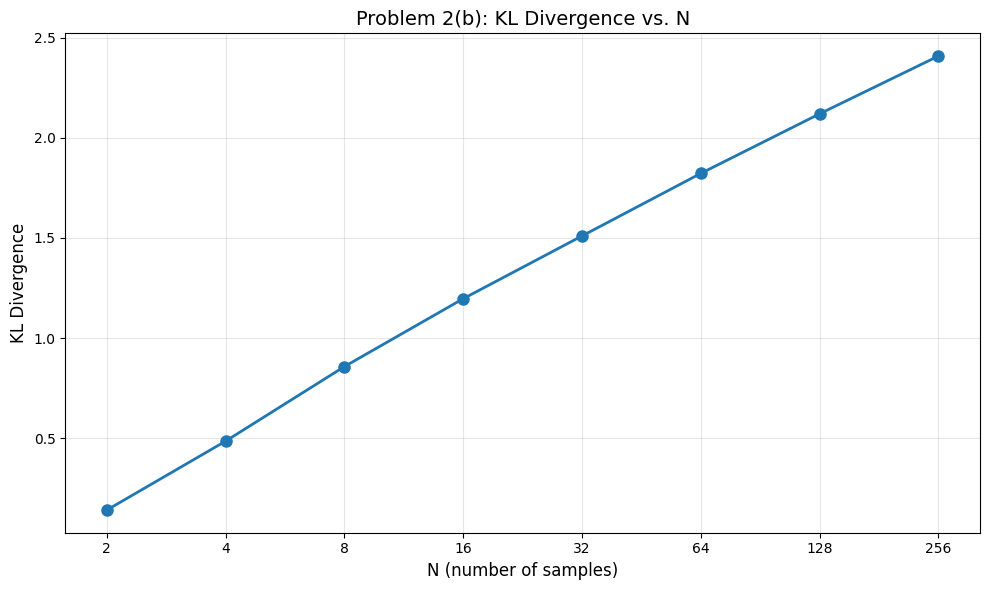

In [12]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    return np.log(n)-((n-1)/n)

def kl_divergence_numerical(p, q):
    epsilon = 1e-10
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon
    # Normalize
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(p * np.log(p / q))

kl_divergences = []
# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [2, 4, 8, 16, 32, 64, 128, 256]:
    # todo
    probs_optimized, bins = optimized_prob_distribution(n, reward_model_proxy_hacked)
    kl_divergence = kl_divergence_numerical(probs_optimized, probs_initial)
    kl_divergences.append(kl_divergence)
    print(f"n={n}, kl_divergence={kl_divergence:.3f}")

# plot
plt.figure(figsize=(10, 6))
plt.plot([2, 4, 8, 16, 32, 64, 128, 256], kl_divergences, marker='o', linewidth=2, markersize=8)
plt.xlabel("N (number of samples)", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.title("Problem 2(b): KL Divergence vs. N", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks([2, 4, 8, 16, 32, 64, 128, 256], [2, 4, 8, 16, 32, 64, 128, 256])
plt.tight_layout()
plt.show()

N =    2: reward proxy = 4.3178, reward ground truth = 4.2750
N =    4: reward proxy = 4.7020, reward ground truth = 4.5498
N =    8: reward proxy = 4.8713, reward ground truth = 4.6896
N =   16: reward proxy = 5.0716, reward ground truth = 4.7061
N =   32: reward proxy = 5.1997, reward ground truth = 4.8041
N =   64: reward proxy = 5.3005, reward ground truth = 4.7699
N =  128: reward proxy = 5.3571, reward ground truth = 4.6310
N =  256: reward proxy = 5.3951, reward ground truth = 4.6703
N =  512: reward proxy = 5.4306, reward ground truth = 4.6281
N = 1024: reward proxy = 5.4545, reward ground truth = 4.4032
N = 2048: reward proxy = 5.4674, reward ground truth = 4.4891


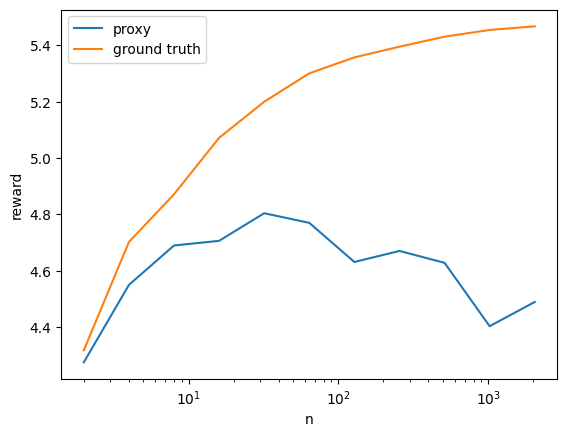

In [ ]:
# 2c
def estimate_reward(n:int, reward_model: Callable) -> float:
    # TODO
    proxy_rewards = []
    ground_truth_rewards = []

    for _ in range(100):
        best_output, proxy_reward = best_of_n(n, reward_model_proxy_hacked)

        proxy_rewards.append(proxy_reward)
        gt_reward = reward_model_ground_truth(best_output)
        ground_truth_rewards.append(gt_reward)

    return np.mean(proxy_rewards), np.mean(ground_truth_rewards)


rewards_ground_truth: list[float] = []
rewards_proxy: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward(n, reward_model_proxy_hacked)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)
    print(f"N = {n:4d}: reward proxy = {reward_proxy:.4f}, reward ground truth = {reward_ground_truth:.4f}")


# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['proxy', 'ground truth'])
plt.show()